In [1]:
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tifffile

from utils.tools import get_raster_data, read_geojson, show, save_raster_and_write_meta


In [2]:
clipped_satellite_file = "clipped_satellite.tif"
imgA, _, _, _ = get_raster_data(clipped_satellite_file) 
imgA = np.transpose(imgA, (1, 2, 0))  # Convert from (bands, height, width) to (height, width, bands)

post_clipped_image_file = "post_clipped_image.tif"
imgB, _, _, _ = get_raster_data(post_clipped_image_file) 
imgB = np.transpose(imgB, (1, 2, 0))  # Convert from (bands, height, width) to (height, width, bands)

Dataset name: clipped_satellite.tif
File mode: r
Number of bands: 3
Image width: 578 pixels
Image height: 364 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (3, 364, 578)
Data type: uint8
Dataset name: post_clipped_image.tif
File mode: r
Number of bands: 4
Image width: 677 pixels
Image height: 426 pixels
Coordinate Reference System (CRS): EPSG:32647
Data shape: (4, 426, 677)
Data type: uint8


In [3]:
%matplotlib widget

from math import floor
from plantcv.plantcv.annotate.points import _find_closest_pt

class Corrsponding_Points:
    """Corrsponding points collection  
    """

    def __init__(self, imgA, imgB, marker_A='x', marker_B="x", marker_color_A="red", marker_color_B="red", figsize=(12, 6)):
        """
        Initialization
        :param img: image data
        :param figsize: desired figure size, (12,6) by default
        :attribute points: list of points as (x,y) coordinates tuples
        """ 
        self.markers = {}
        self.markers[0] = marker_A
        self.markers[1] = marker_B
        self.markers_color = {}
        self.markers_color[0] = marker_color_A
        self.markers_color[1] = marker_color_B
        

        self.fig, self.axs = plt.subplots(1, 2, figsize=figsize) 
        self.axs[0].imshow(imgA[:,:,0:3])  # Display the first three channels (RGB) of the clipped image
        self.axs[0].set_title('Google') # Set a title for the first subplot 

        self.axs[1].imshow(imgB[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
        self.axs[1].set_title('Theos') # Set a title for the second subplot 


        self.points = {}
        self.points[0] = []
        self.points[1] = []


        self.events = {}
        self.events[0] = []
        self.events[1] = []
        self.fig.tight_layout()
        self.fig.canvas.mpl_connect('button_press_event', self.onclick)


    def click(self, event, which_axis=0):
    
        if event.button == 1:

            self.axs[which_axis].plot(event.xdata, event.ydata, self.markers[which_axis], c=self.markers_color[which_axis])
            self.points[which_axis].append((floor(event.xdata), floor(event.ydata)))

        else:
            idx_remove, _ = _find_closest_pt((event.xdata, event.ydata), self.points[which_axis])
            # remove the closest point to the user right clicked one
            self.points[which_axis].pop(idx_remove)
            self.axs[which_axis].lines[idx_remove].remove()


    def onclick(self, event):
        """Handle mouse click events"""
        
        if event.inaxes is not None:
            clicked_ax = event.inaxes
            
            if clicked_ax is self.axs[0]:
                self.axs[0].set_title("On")
                self.axs[1].set_title("Off")
                self.events[0].append(event)
                self.click(event, which_axis=0)

            elif clicked_ax is self.axs[1]:
                self.axs[0].set_title("Off")
                self.axs[1].set_title("On")
                self.events[1].append(event)
                self.click(event,  which_axis=1)
                
            self.fig.canvas.draw()
        else:
            print("Clicked outside any axes")
        
         

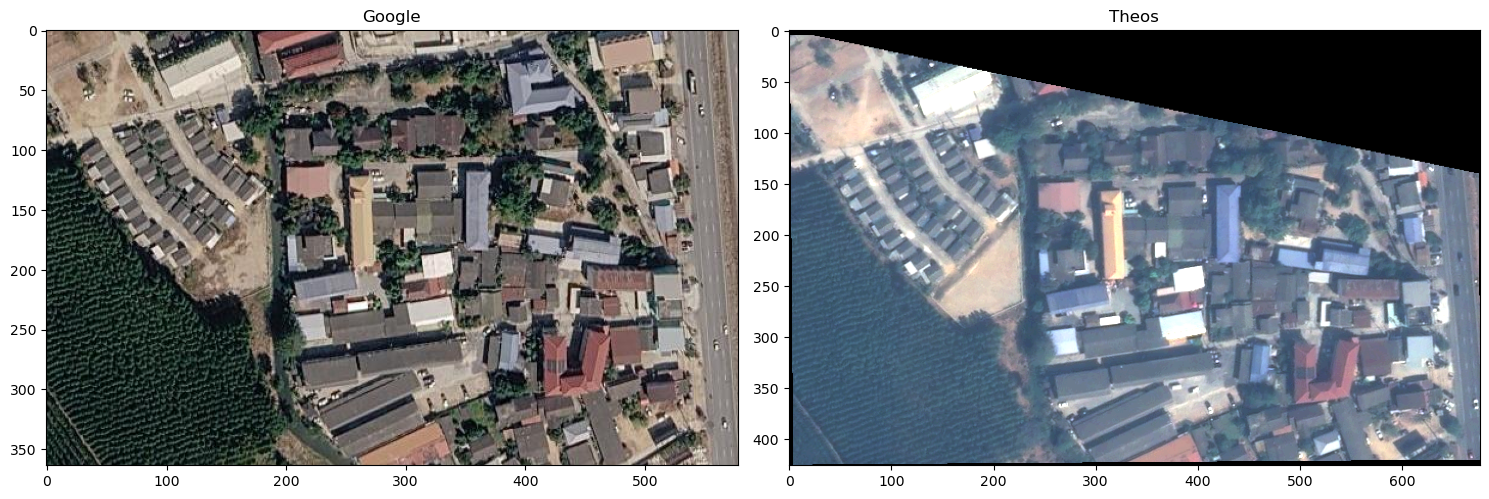

In [4]:
marker_AB = Corrsponding_Points(imgA, imgB, figsize=(15, 5))

In [ ]:
import cv2

point_src  = np.array(marker_AB.points[0])
point_dst  = np.array(marker_AB.points[1])

Homography, status = cv2.findHomography(point_src, point_dst)

size = (imgB.shape[1], imgB.shape[0])
im_dst = cv2.warpPerspective(imgA, Homography, size)

Text(0.5, 1.0, 'Google (warped)')

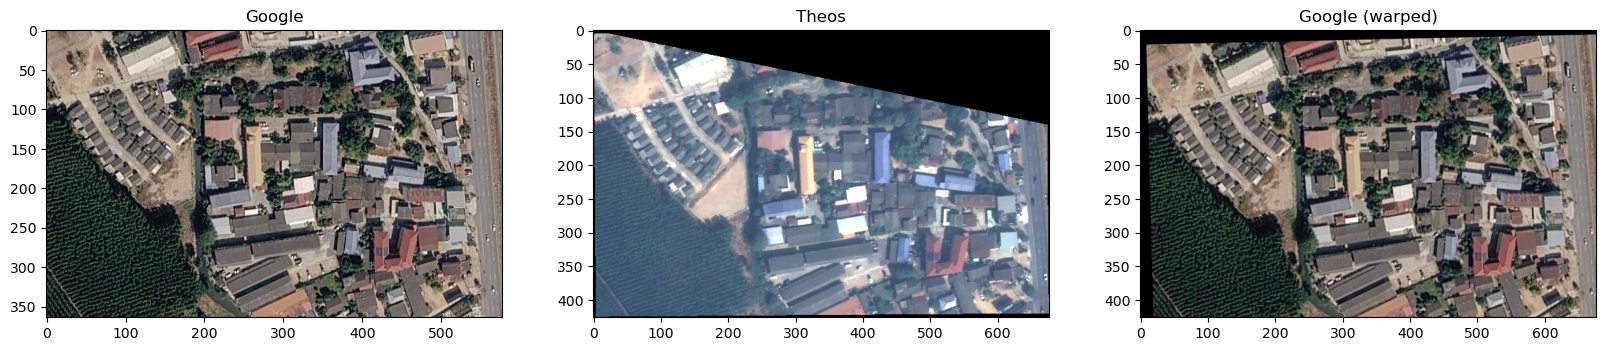

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20,5)) 
axs[0].imshow(imgA[:,:,0:3])  # Display the first three channels (RGB) of the clipped image
axs[0].set_title('Google') # Set a title for the first subplot 

axs[1].imshow(imgB[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
axs[1].set_title('Theos') # Set a title for the second subplot 

axs[2].imshow(im_dst[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
axs[2].set_title('Google (warped)') # Set a title for the second subplot 

In [ ]:
im_dst_4D = np.zeros((imgB.shape[0], imgB.shape[1], 4)) 
im_dst_4D[:,:,:3] = im_dst 
im_dst_4D[:,:, 3] = 253
im_dst_4D = im_dst_4D.transpose(2, 0, 1)

In [17]:
destination_tif = "warpped_clipped_satellite.tif"
meta_source_tif = post_clipped_image_file
save_raster_and_write_meta(im_dst_4D , destination_tif, meta_source_tif)

Modified image saved to warpped_clipped_satellite.tif


In [19]:
import leafmap.leafmap as leafmap
m = leafmap.Map()
m.add_raster(post_clipped_image_file, layer_name="theos") 
m.add_raster(clipped_satellite_file, layer_name="Google") 
m.add_raster(destination_tif, layer_name="Google (warpped)") 
m

Map(center=[13.053346999999999, 100.92455100000001], controls=(ZoomControl(options=['position', 'zoom_in_text'…